# 批量规范化
> 批量规范化（batchnormalization）(Ioffe and Szegedy, 2015)，这是⼀种流⾏且有效的技术，可持续加速深层⽹络的收敛速度。再结合在下一节中将介绍的残差块，批量规范化使得研究⼈员能够训练100层以上的⽹络。


## 1. 训练深层网络
+ 为什么需要批量规范化层呢？
    + ⾸先，数据预处理的⽅式通常会对最终结果产⽣巨⼤影响
    + 对于典型的多层感知机或卷积神经⽹络。当我们训练时，中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更⼴的变化范围
    + 更深层的⽹络很复杂，容易过拟合。这意味着正则化变得更加重要。
 
+ 批量规范化应⽤于单个可选层（也可以应⽤到所有层），其原理如下：在每次训练迭代中，我们⾸先规范化输⼊，即通过减去其均值并除以其标准差，其中两者均基于当前⼩批量处理。接下来，我们应⽤⽐例系数和⽐例偏移。正是由于这个基于批量统计的标准化，才有了批量规范化的名称。 

+ 另外，批量规范化层在”训练模式“（通过⼩批量统计数据规范化）和“预测模式”（通过数据集统计规范化）中的功能不同。在训练过程中，我们⽆法得知使⽤整个数据集来估计平均值和⽅差，所以只能根据每个⼩批次的平均值和⽅差不断训练模型。⽽在预测模式下，可以根据整个数据集精确计算批量规范化所需的平均值和⽅差。



## 2.批量规范化层
+ 全连接层：通常，我们将批量规范化层置于全连接层中的仿射变换和激活函数之间。
+ 卷积层：对于卷积层，我们可以在卷积层之后和⾮线性激活函数之前应⽤批量规范化。当卷积有多个输出通道时，我们需要对这些通道的“每个”输出执⾏批量规范化。

![batch-normalization](images/bn.png)

## 3，BN实现

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式为训练还是测试
    if not torch.is_grad_enabled():
        # 测试
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4) # 2为linear 4为Conv
        if len(X.shape) == 2:
            # 全连接层
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 二维卷积
            mean = X.mean(dim=(0, 2 ,3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        X_hat = (X - mean) . torch.sqrt(var + eps)
        # 更新均值和方差
        moving_mean = momentum * moving_mean + (1 - momentum) * mean
        moving_var = momentum * moving_var + (1 - momentum) * var
    Y = gamma * X_hat + beta # 缩放和位移
    return Y, moving_mean, moving_var
        

## 4. 使用BN的LeNet

In [2]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.354, train acc 0.875, test acc 0.802
75680.7 examples/sec on cuda:0


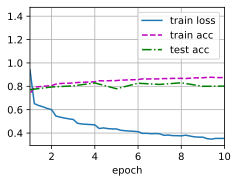

In [3]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())